In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize as opt

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor

from skforecast.direct import ForecasterDirect, ForecasterDirectMultiVariate
from skforecast.recursive import ForecasterRecursive, ForecasterSarimax
from skforecast.sarimax import Sarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster, backtesting_sarimax, grid_search_forecaster

import catboost
from catboost import CatBoostRegressor

import tqdm

In [2]:
df_prices = pd.read_csv('../code/data/crypto.csv', index_col='dt', parse_dates=['dt'])
df_prices.drop('TON-USDT', axis=1, inplace=True)
df_prices.columns = [c.split('-')[0] for c in df_prices.columns]
df_prices.head()

,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2020-01-01 19:00:00,7131.9,129.56,NaN,NaN,0.19050,NaN,0.01312,41.17
2020-01-02 19:00:00,7319.7,132.47,NaN,NaN,0.19203,NaN,0.01337,41.76
2020-01-03 19:00:00,7318.9,133.29,NaN,NaN,0.19249,NaN,0.01335,42.28
2020-01-04 19:00:00,7467.4,137.24,NaN,NaN,0.19628,NaN,0.01377,44.01
2020-01-05 19:00:00,7520.9,140.18,NaN,NaN,0.21275,NaN,0.01405,44.06


In [4]:
days_shift = 7
df_returns = df_prices.diff(days_shift) / df_prices.shift(days_shift)
df_returns = df_returns[df_returns.isna().sum(axis=1) == 0]
df_returns = df_returns[df_returns.index >= '2022-01-01']

n_observations, n_assets = df_returns.shape
print(n_observations, n_assets)
df_returns.head()

1095 8


,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2022-01-01 19:00:00,-0.054014,-0.067913,-0.005263,-0.048031,-0.067994,-0.110254,-0.035776,-0.023856
2022-01-02 19:00:00,-0.092438,-0.075290,-0.067066,-0.070249,-0.103108,-0.151931,-0.058294,-0.065561
2022-01-03 19:00:00,-0.041478,-0.012844,0.008603,-0.035905,-0.054473,-0.072116,-0.022158,-0.004834
2022-01-04 19:00:00,-0.028151,0.006730,0.044412,-0.048068,-0.019920,-0.045850,-0.012687,-0.005669
2022-01-05 19:00:00,-0.088865,-0.083878,-0.050395,-0.093272,-0.089935,-0.138798,-0.092972,-0.086360


In [5]:
y = df_returns['BTC'].reset_index(drop=True)
y

0      -0.054014
1      -0.092438
2      -0.041478
3      -0.028151
4      -0.088865
          ...   
1090   -0.031560
1091   -0.009079
1092   -0.012196
1093   -0.029430
1094   -0.041456
Name: BTC, Length: 1095, dtype: float64

In [7]:
lr = ForecasterRecursive(
    regressor=LinearRegression(),
    lags=range(1, 8),
)

arma = ForecasterSarimax(
    regressor=Sarimax(order=(1, 0, 1)),
)

# cb = ForecasterRecursive(
#     regressor=CatBoostRegressor(),
#     lags=range(1, 8),
# )

ada = ForecasterRecursive(
    regressor=AdaBoostRegressor(),
    lags=range(1, 8),
)

In [7]:
y_train, y_test = train_test_split(y, test_size=0.2, shuffle=False)

In [8]:
def mse_last_value(y_true, y_pred):
    idxs = range(0, len(y_true), days_shift)
    return metrics.mean_squared_error(y_true.iloc[idxs], y_pred.iloc[idxs])

In [9]:
cv = TimeSeriesFold(
    steps=days_shift,
    initial_train_size=50,
    refit=True,
)
metric, pred = backtesting_forecaster(
    forecaster=lr,
    y=y,
    cv=cv,
    metric=mse_last_value,
    n_jobs=-1,
)

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 1050 times (150 folds * 7 regressors). This can take      │
│ substantial amounts of time. If not feasible, try with `refit = False`.              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\skforecast\model_selec │
│ tion\_validation.py:231                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/150 [00:00<?, ?it/s]

In [8]:
def portfolio_optimizer(mu_hat, cov_hat, tau):
    def objective(w):
        w = w.reshape((-1, 1))
        return (w.T @ cov_hat @ w - tau * w.T @ mu_hat).item()
        
    def unit_portfolio(w):
        return np.abs(w).sum() - 1
        
    eq_cons = {
        'type': 'eq',
        'fun': unit_portfolio,
    }
    bounds = [(-1, 1) for i in range(n_assets)]
    x0 = np.ones(n_assets) / n_assets
    sol = opt.minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons]
    )
    if sol.success:
        return sol.x

In [44]:
def frontier_evaluator(mu_hat, cov_hat, ret_true):
    frontier_tau = np.linspace(0.01, 1, 5)
    frontier = np.full_like(frontier_tau, np.nan)
    for i in range(len(frontier_tau)):
        tau = frontier_tau[i]
        w = portfolio_optimizer(mu_hat, cov_hat, tau)
        if w is None:
            print('not converged')
            continue
        roi = np.dot(w, ret_true)
        frontier[i] = roi
    return frontier

In [10]:
# mu estimators

def naive_estimator(df_hist):
    return df_hist.mean(axis=0)

def martingal_estimator(df_hist):
    return df_hist.iloc[-1]

def lr_estimator(df_hist):
    mu_hat = []
    for c in df_hist.columns:
        y = df_hist[c].reset_index(drop=True)
        lr.fit(y)
        mu_hat.append(lr.predict(days_shift).iloc[-1])
    return np.array(mu_hat)

def arma_estimator(df_hist):
    mu_hat = []
    for c in df_hist.columns:
        y = df_hist[c].reset_index(drop=True)
        arma.fit(y)
        mu_hat.append(arma.predict(days_shift).iloc[-1])
    return np.array(mu_hat)
    
def catboost_estimator(df_hist):
    mu_hat = []
    for c in df_hist.columns:
        y = df_hist[c].reset_index(drop=True)
        cb.fit(y)
        mu_hat.append(cb.predict(days_shift).iloc[-1])
    return np.array(mu_hat)

def adaboost_estimator(df_hist):
    mu_hat = []
    for c in df_hist.columns:
        y = df_hist[c].reset_index(drop=True)
        ada.fit(y)
        mu_hat.append(ada.predict(days_shift).iloc[-1])
    return np.array(mu_hat)

In [17]:
df_returns.shape

(1095, 8)

In [51]:
threshold_date = '2024-01-01'
df_returns_test = df_returns[df_returns.index >= threshold_date]
df_returns_train = df_returns[df_returns.index < threshold_date]
df_returns_train.shape, df_returns_test.shape

((729, 8), (366, 8))

In [53]:
n_assets = df_returns.shape[1]

idx_most_risky = np.argmax(df_returns_train.describe().T['std'])
idx_less_risky = np.argmin(df_returns_train.describe().T['std'])
idx_best_return = np.argmax(df_returns_train.describe().T['mean'])
idx_worst_return = np.argmin(df_returns_train.describe().T['mean'])
print(idx_most_risky, idx_less_risky, idx_best_return, idx_worst_return)

def single_asset_portfolio_builder(idx):
    w =  np.zeros(n_assets)
    w[idx] = 1
    return w

def uniform_portfolio_builder():
    return np.full(n_assets, 1 / n_assets)


5 6 3 2


In [45]:
results_frontier = []
results_trivial = []

min_history_leng = 66
total_runs = df_returns_test.shape[0] - days_shift - min_history_leng
total_runs = 50
print(total_runs)


mu_estimators = [
    ('naive', naive_estimator),
    ('martingal', martingal_estimator),
    ('lr', lr_estimator),
    ('arma', arma_estimator),
    ('ada', adaboost_estimator),
]

trivial_portfolios = [
    ('uniform', uniform_portfolio_builder()),
    ('most_risky', single_asset_portfolio_builder(idx_most_risky)),
    ('less_risky', single_asset_portfolio_builder(idx_less_risky)),
    ('best_return', single_asset_portfolio_builder(idx_best_return)),
    ('worst_return', single_asset_portfolio_builder(idx_worst_return)),
]

for t in tqdm.trange(total_runs):
    # prepare data
    idx_history = min_history_leng + t
    idx_future = idx_history + days_shift - 1
    df_history = df_returns_test.iloc[:idx_history]
    df_future = df_returns_test.iloc[idx_future]

    # estimate cov, common for all models
    cov_hat = df_history.cov().values

    # estimate mu using list of models
    frontiers = []
    for name, mu_estimator in mu_estimators:
        mu_hat = mu_estimator(df_history)
        
        # evaluate each portfolio in frontier for currnet model
        roi_frontier = frontier_evaluator(mu_hat, cov_hat, df_future.values)
        frontiers.append(roi_frontier)
    results_frontier.append(frontiers)
    
    # evaluate trivial strategies 
    trivials = []
    for name, w in trivial_portfolios:
        roi = np.dot(w, df_future.values).item()
        trivials.append(roi)
    results_trivial.append(trivials)


50


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

not converged
not converged


  2%|█▋                                                                                 | 1/50 [00:02<02:12,  2.71s/it]

not converged
not converged
not converged


  4%|███▎                                                                               | 2/50 [00:05<02:13,  2.79s/it]

not converged
not converged
not converged
not converged
not converged
not converged
not converged
not converged


  6%|████▉                                                                              | 3/50 [00:08<02:11,  2.80s/it]

not converged
not converged
not converged
not converged


  8%|██████▋                                                                            | 4/50 [00:11<02:08,  2.79s/it]

not converged
not converged
not converged
not converged
not converged
not converged
not converged
not converged


 10%|████████▎                                                                          | 5/50 [00:13<02:05,  2.80s/it]

not converged
not converged
not converged
not converged


 12%|█████████▉                                                                         | 6/50 [00:16<02:01,  2.76s/it]

not converged
not converged
not converged


 14%|███████████▌                                                                       | 7/50 [00:19<01:57,  2.73s/it]

not converged
not converged


 16%|█████████████▎                                                                     | 8/50 [00:21<01:52,  2.69s/it]

not converged
not converged


 18%|██████████████▉                                                                    | 9/50 [00:24<01:51,  2.72s/it]

not converged
not converged
not converged


 20%|████████████████▍                                                                 | 10/50 [00:27<01:47,  2.70s/it]

not converged
not converged


 22%|██████████████████                                                                | 11/50 [00:29<01:42,  2.64s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


not converged
not converged
not converged


 26%|█████████████████████▎                                                            | 13/50 [00:35<01:36,  2.61s/it]

not converged
not converged
not converged
not converged


 28%|██████████████████████▉                                                           | 14/50 [00:37<01:33,  2.60s/it]

not converged
not converged


 30%|████████████████████████▌                                                         | 15/50 [00:40<01:32,  2.64s/it]

not converged
not converged
not converged


 34%|███████████████████████████▉                                                      | 17/50 [00:45<01:24,  2.57s/it]

not converged
not converged
not converged


 36%|█████████████████████████████▌                                                    | 18/50 [00:47<01:20,  2.53s/it]

not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 38%|███████████████████████████████▏                                                  | 19/50 [00:50<01:18,  2.55s/it]

not converged
not converged
not converged
not converged
not converged


 44%|████████████████████████████████████                                              | 22/50 [00:58<01:11,  2.56s/it]

not converged
not converged
not converged


 46%|█████████████████████████████████████▋                                            | 23/50 [01:00<01:09,  2.57s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


not converged
not converged


 50%|█████████████████████████████████████████                                         | 25/50 [01:05<01:03,  2.54s/it]

not converged


 52%|██████████████████████████████████████████▋                                       | 26/50 [01:08<00:59,  2.48s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 54%|████████████████████████████████████████████▎                                     | 27/50 [01:10<00:57,  2.49s/it]

not converged
not converged
not converged
not converged


 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:13<00:54,  2.49s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:15<00:52,  2.50s/it]

not converged
not converged


 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:18<00:49,  2.49s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:20<00:47,  2.50s/it]

not converged
not converged


 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:23<00:44,  2.49s/it]

not converged
not converged


 66%|██████████████████████████████████████████████████████                            | 33/50 [01:25<00:41,  2.45s/it]

not converged


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:30<00:36,  2.44s/it]

not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:32<00:33,  2.43s/it]

not converged


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:35<00:31,  2.41s/it]

not converged


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:39<00:26,  2.40s/it]

not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


not converged
not converged


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:42<00:24,  2.45s/it]

not converged
not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


not converged
not converged


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:45<00:22,  2.53s/it]

not converged
not converged
not converged
not converged
not converged
not converged
not converged


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:47<00:20,  2.60s/it]

not converged
not converged


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:50<00:18,  2.61s/it]

not converged
not converged
not converged


C:\Users\tpolu\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:53<00:15,  2.60s/it]

not converged
not converged


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:55<00:12,  2.52s/it]

not converged
not converged
not converged
not converged


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:57<00:10,  2.51s/it]

not converged
not converged
not converged
not converged


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:00<00:07,  2.51s/it]

not converged
not converged
not converged
not converged
not converged
not converged


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:03<00:05,  2.55s/it]

not converged
not converged
not converged
not converged


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.56s/it]

not converged


In [46]:
np.array(results_trivial).mean(axis=0), np.array(results_trivial).std(axis=0)

(array([-0.02310812, -0.00117554, -0.01581977, -0.02876441, -0.05718594]),
 array([0.0700132 , 0.15196405, 0.06255487, 0.08308433, 0.10020013]))

In [47]:
frontier_means = np.nanmean(results_frontier, axis=0)
frontier_stds = np.nanstd(results_frontier, axis=0)

trivial_means = np.mean(results_trivial, axis=0)
trivial_stds = np.std(results_trivial, axis=0)

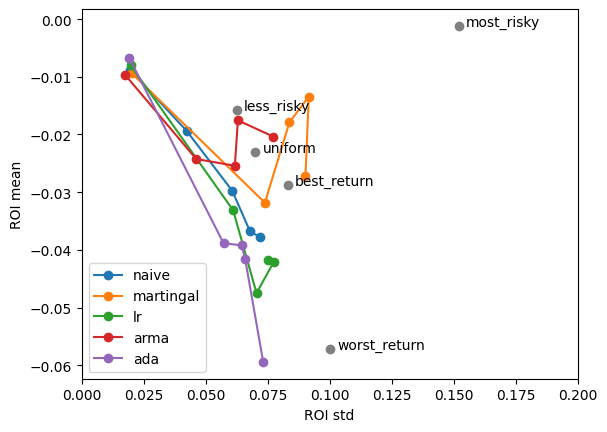

In [57]:
fig, ax = plt.subplots()
for m, s, (label, _) in zip(frontier_means, frontier_stds, mu_estimators):
    ax.plot(s, m, marker='o', label=label)

ax.scatter(trivial_stds, trivial_means, color='grey')
for s, m, (name, _) in zip(trivial_stds, trivial_means, trivial_portfolios):
    ax.text(s + 0.003, m, name)
    
ax.set_xlabel('ROI std')
ax.set_ylabel('ROI mean')
ax.set_xlim(0, 0.2)
ax.legend()

In [122]:
forecaster = ForecasterDirectMultiVariate(
    regressor=Ridge(random_state=27),
    steps=days_shift,
    lags=5,
)

# Lags used as predictors
lags_grid = {
    'lags_1': 1,
    'lags_2': [1, 7],
    'lags_3': range(1, 8)
}

# Regressor hyperparameters
param_grid = {
    'alpha': [0.01, 0.1, 1, 10]
}

# Folds
cv = TimeSeriesFold(
         steps=days_shift,
         initial_train_size=50,
         refit=False
     )

results = grid_search_forecaster(
              forecaster=forecaster,
              y=y,
              param_grid=param_grid,
              lags_grid=lags_grid,
              cv=cv,
              metric=mse_last_value,
              return_best=True,
              n_jobs='auto',
              verbose=False,
              show_progress=True
          )
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1] 
  Parameters: {'alpha': 10}
  Backtesting metric: 0.03184047710184139


,lags,lags_label,params,mse_last_value,alpha
0,[1],lags_1,{'alpha': 10},0.031840,10.00
1,[1],lags_1,{'alpha': 1},0.031946,1.00
2,[1],lags_1,{'alpha': 0.1},0.032145,0.10
3,[1],lags_1,{'alpha': 0.01},0.032207,0.01
4,"[1, 2, 3, 4, 5, 6, 7]",lags_3,{'alpha': 0.01},0.041003,0.01
5,"[1, 2, 3, 4, 5, 6, 7]",lags_3,{'alpha': 10},0.044432,10.00
6,"[1, 7]",lags_2,{'alpha': 1},0.044449,1.00
7,"[1, 7]",lags_2,{'alpha': 10},0.044678,10.00
8,"[1, 2, 3, 4, 5, 6, 7]",lags_3,{'alpha': 1},0.045082,1.00
9,"[1, 7]",lags_2,{'alpha': 0.1},0.045718,0.10
